In [12]:
import GraphDB.DataCitation as dc
import queries_for_testing as q
from datetime import datetime, timedelta, timezone
from IPython.display import Image

# Preparing the data and query store

## R1 - Data Versioning

Coming from relational databases a triple store can be imagined as a table with three fields - subject, predicate, object. if one were about to annotate a triple with a timestamp or other label the fact that no additional “column” can be used within a triple store but only additional rows would make it hard to reference a specific triple. All that could be done is to insert another triple to somehow reference the target triple. However, where would this new triple point at or what would be the subject? Figure 1 illustrates this problem


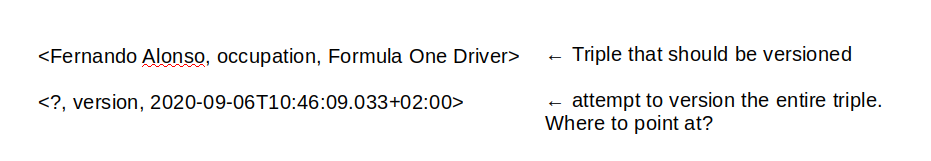

In [14]:
Image(filename='figures/figure 1.png')

One can easily see the problem that the placeholder ? can only take one piece of information (subject or object) of the target triple which does not suffice to reference the triple as a whole. However, if one were able to nest a whole triple within the subject of another it would endow us with the right tool to address data versioning within triple stores. In fact, RDF* and SPARQL* as extensions of RDF and SPARQL respectively are capable of doing exactly this. Figure 2 illustrates the solution for the example brought in figure 1 in actual RDF* syntax.


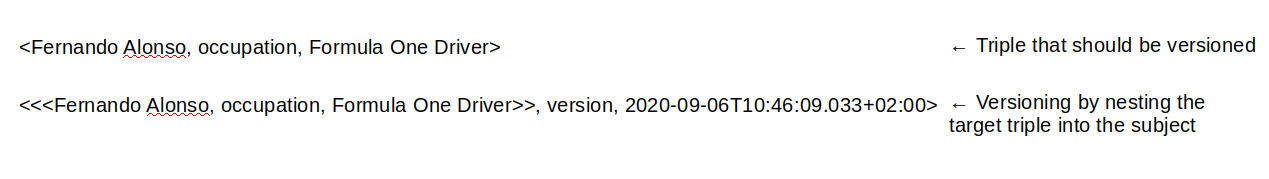

In [15]:
Image(filename='figures/figure 2.png')

This capability of nesting triples is only part of the solution. However, now we can use existing methods that also can be used within relational databases. One way is to use a start and an end date for each triple. As an initial operation all triples should be annotated with the current timestamp as the start date and an end date that is far in the future, e.g. 9999-12-31T00:00.000. From here we have to distinguish between insert, update and delete operations. Finally, to retrieve data as it existed at a certain point in time we would use simple filter operations on the start date and end date attributes. 


## R2 - Timestamping 

## R3 - Query Store Facilities

# Persistently Identify Specific Data Sets

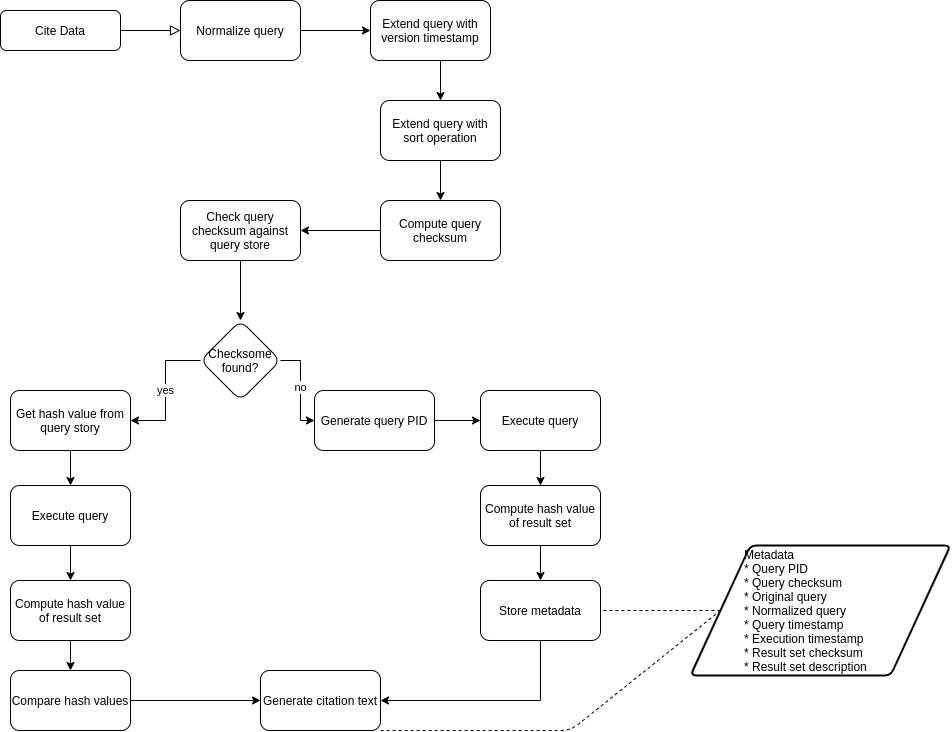

In [13]:
Image(filename='figures/figure 5.png')

Every time a data set should be persisted the following operations are performed. First, the query is normalized (R4) and the version timestamp (R7) is embedded in the query text. The latter operation ensures that two identical queries with different query timestamps will also get different PIDs. It needs to be pointed out that the version timestamp is not the execution timestamp but the timestamp of the last write operation in the returned dataset. This means that two queries with different execution timestamps can result in the same checksum if no write operations were made in between the two queries. It also consequently means that two different version timestamps on an otherwise identical query will result in different result sets.
Then, the normalised query is extended with a sorting operation (R5) which sorts the data by the alphabetical order of the columns in the select section. 
Next, a query checksum is computed (R4) and checked against the query store whether the same checksum already exists.
* If yes, the PID of the query is returned and embedded into the generated citation text (R10). The citation text can vary from community to community, therefore it is a custom function which can be customized within the framework. 
* Otherwise, a new PID is generated for that query (R8). The query is executed and a hash value is computed for the result set (R6). All the metadata is stored as described in R3 (R9). The newly generated PID is embedded into the citation text which is defined by a custom function and returned to the user (R10)

In the following cells a test query will be prepared which will be used for two Data Citation use cases described below.


In [2]:
# set up endpoints
citing = dc.DataVersioning('http://192.168.0.242:7200/repositories/DataCitation', #GET
                           'http://192.168.0.242:7200/repositories/DataCitation/statements') #POST

In [3]:
# prepare test query
prefixes = {'citing': 'http://ontology.ontotext.com/citing/',
            'pub': 'http://ontology.ontotext.com/taxonomy/',
            'xsd': 'http://www.w3.org/2001/XMLSchema#',
            'publishing': 'http://ontology.ontotext.com/publishing#'}

original_query = """
select * where {

    ?document publishing:containsMention ?mention .
    ?mention publishing:hasInstance ?person .
    ?person pub:preferredLabel ?personLabel .
    ?person pub:memberOfPoliticalParty ?party .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel "Democratic Party"@en .
    filter(?personLabel = "Judy Chu"@en)
}
"""

## Use Case: Retrieve cited data set 

In [4]:
# prepare test case with test query
vieTZObject = timezone(timedelta(hours=2))
timestamp = datetime(2020, 9, 8, 12, 11, 21, 941000, vieTZObject)
df = citing.get_data_at_timestamp(original_query,timestamp, prefixes)
df

,document,person,personLabel,party,value,mention
0,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://ontology.ontotext.com/resource/tsm835hi3s3k,Judy Chu@en,http://ontology.ontotext.com/resource/Q460035S071C8FD6-DA5F-4189-81A7-D589D13B2D09,http://ontology.ontotext.com/resource/tsk5a9unh5a8,http://data.ontotext.com/publishing#Mention-dbaa4de4563be5f6b927c87e09f90461c09451296f4b52b1f80dcb6e941a5acd
1,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://ontology.ontotext.com/resource/tsm835hi3s3k,Judy Chu@en,http://ontology.ontotext.com/resource/Q460035S071C8FD6-DA5F-4189-81A7-D589D13B2D09,http://ontology.ontotext.com/resource/tsk5a9unh5a8,http://data.ontotext.com/publishing#Mention-f5eb5422f2a33ff188b30ab0b983ab18b33f39b383be10f812c153230b73865d
2,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://ontology.ontotext.com/resource/tsm835hi3s3k,Judy Chu@en,http://ontology.ontotext.com/resource/Q460035S071C8FD6-DA5F-4189-81A7-D589D13B2D09,http://ontology.ontotext.com/resource/tsk5a9unh5a8,http://data.ontotext.com/publishing#Mention-69cd96b08117cf60238c40a3d95c949a778288a68458716fb5f1400a4fdd30dc
3,http://www.reuters.com/article/2014/10/10/us-usa-california-mountains-idUSKCN0HZ0U720141010,http://ontology.ontotext.com/resource/tsm835hi3s3k,Judy Chu@en,http://ontology.ontotext.com/resource/Q460035S071C8FD6-DA5F-4189-81A7-D589D13B2D09,http://ontology.ontotext.com/resource/tsk5a9unh5a8,http://data.ontotext.com/publishing#Mention-1a777ce18aed8d438a8f292f82520d87755062fec533c97ba61cb0f3fbc22e19


## Use case: Cite data set

In [5]:
print(original_query)


select * where {

    ?document publishing:containsMention ?mention .
    ?mention publishing:hasInstance ?person .
    ?person pub:preferredLabel ?personLabel .
    ?person pub:memberOfPoliticalParty ?party .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel "Democratic Party"@en .
    filter(?personLabel = "Judy Chu"@en)
}



### R4a - Query uniqueness: Normalize query

| Statement description | Normalization measure   |
|------|------|
| WHERE clause is optional | A where clause will always be inserted |
| "rdf:type" predicate can be replaced by "a" | rdf:type will always be replaced by "a" |
| if all subjects are selected one does not need to write a variable in the form ?s but can just use an asterisk | Variables will always be explicitely mentioned and ordered alphabetically |
| If the same subject is used multiple times in subsequent triplets separated by a dot it can be simplified by writing just the first subject variable name, separating the triplets by semicolons and leaving out the other variable names that are equal to the one in the first triplet | Triples will never be simplified and simplified triples will be made explicit |
|   The order of triple statements does not affect the outcome | Triple statements will be ordered alphabetically by subject, predicate, object |
| Aliases via BIND keyword just rename variables but the query result stays the same  | Do not know how to tackle yet |
| Variable names in general can differ between two queries without changing the outcome.  | Do not know how to tackle this yet. |
| Finding variables that are not bound can be written in two ways: 1. with optional keyword adding the optional triplet combined with filter condition !bound(?var); 2. with "filter not exists (triplet)" | No solution yet |
| Inverting the order of the triplet (object predicate subject instead of subject predicate object) using "^" gives the same results | Inverted triples will be back-inverted and "^" will thereby be removed |
| sequence paths can reduce the number of triplets in the query statement and are commonly used. | Sequence paths will be made explicit in form triple statements |


In [6]:
# Normalize query
normalized_query = dc.normalize_query(original_query)
print(normalized_query)


select * where {

    ?document publishing:containsMention ?mention .
    ?mention publishing:hasInstance ?person .
    ?person pub:preferredLabel ?personLabel .
    ?person pub:memberOfPoliticalParty ?party .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel "Democratic Party"@en .
    filter(?personLabel = "Judy Chu"@en)
}



### R7 - Query Timestamping
Extend query with version timestamp based on the last update to the selection of data affected by the query

In [7]:
extended_query = dc.extend_query_with_timestamp(normalized_query, timestamp, prefixes)
print(extended_query)


    # prefixes
    PREFIX citing:<http://ontology.ontotext.com/citing/> 
PREFIX pub:<http://ontology.ontotext.com/taxonomy/> 
PREFIX xsd:<http://www.w3.org/2001/XMLSchema#> 
PREFIX publishing:<http://ontology.ontotext.com/publishing#> 
 
    
    Select ?document ?person ?personLabel ?party ?value ?mention   where {
        { 
        # original query
        
select * where {

    ?document publishing:containsMention ?mention .
    ?mention publishing:hasInstance ?person .
    ?person pub:preferredLabel ?personLabel .
    ?person pub:memberOfPoliticalParty ?party .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel "Democratic Party"@en .
    filter(?personLabel = "Judy Chu"@en)
}

        }
        # version timestamp
        bind("2020-09-08T12:11:21.941000+02:00"^^xsd:dateTime as ?TimeOfCiting) 

        # data versioning query extension
        
            <<?value <http://ontology.ontotext.com/taxonomy/preferredLabel> "Democratic Party"@en>> citing:valid_from ?valid

### R5 - Stable Sorting

The normalized and timestamped query is now extended with the order by operation. The columns are ordered alphabetically. 

In [8]:
sorted_query = dc.extend_query_with_sort_operation(extended_query)
print (sorted_query)


    # prefixes
    PREFIX citing:<http://ontology.ontotext.com/citing/> 
PREFIX pub:<http://ontology.ontotext.com/taxonomy/> 
PREFIX xsd:<http://www.w3.org/2001/XMLSchema#> 
PREFIX publishing:<http://ontology.ontotext.com/publishing#> 
 
    
    Select ?document ?person ?personLabel ?party ?value ?mention   where {
        { 
        # original query
        
select * where {

    ?document publishing:containsMention ?mention .
    ?mention publishing:hasInstance ?person .
    ?person pub:preferredLabel ?personLabel .
    ?person pub:memberOfPoliticalParty ?party .
    ?party pub:hasValue ?value .
    ?value pub:preferredLabel "Democratic Party"@en .
    filter(?personLabel = "Judy Chu"@en)
}

        }
        # version timestamp
        bind("2020-09-08T12:11:21.941000+02:00"^^xsd:dateTime as ?TimeOfCiting) 

        # data versioning query extension
        
            <<?value <http://ontology.ontotext.com/taxonomy/preferredLabel> "Democratic Party"@en>> citing:valid_from ?valid

### R4b - Query uniqueness: Compute query checksum